## Code to generate Figure 2 - haplogroup dendogram and frequencies

In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust
import matplotlib.patches as patches

#### setup data

In [2]:
callset = h5py.File('../data/ag1000g.phase1.AR3.1.haplotypes.specific_regions.2L_2358158_2431617.h5', mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)
sample_ids = callset['2L']['samples'][:]
hap_ids = np.array(list(itertools.chain(*[[s + b'a', s + b'b'] for s in sample_ids])))
hap_ids_995F = hap_ids[loc_995F]
hap_ids_995S = hap_ids[loc_995S]
tbl_haplotypes = etl.fromtsv('../data/ag1000g.phase1.AR3.1.haplotypes.meta.txt')
hap_pops = np.array(tbl_haplotypes.values('population'))
hap_pops_995S = hap_pops[loc_995S]
hap_pops_995F = hap_pops[loc_995F]

In [6]:
#altered hapclust.fig_haplotypes_clustered function to feed in the gridspec axis externally - this allows us to have multiple plots in one figure
def fig_haplotypes_clustered_piffle(h,
                                    ax_dend,
                                    ax_freq,
                                    distance_metric='hamming',
                                    linkage_method='single',
                                    truncate_distance=0,
                                    orientation='top',
                                    subplot_ratios=(4, 2),
                                    subplot_pad=0,
                                    despine_offset=5,
                                    count_sort=True,
                                    dend_linecolor='k',
                                    cut_height=2,
                                    highlight_clusters=True,
                                    highlight_colors=None,
                                    highlight_dend=True,
                                    highlight_freq=True,
                                    highlight_alpha=0.3,
                                    label_clusters=True,
                                    dpi=None):

    
    # check inputs
    h = allel.HaplotypeArray(h)
    
    # compute distance matrix
    dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
    if distance_metric in {'hamming', 'jaccard'}:
        # convert distance to number of SNPs, easier to interpret
        dist *= h.n_variants
    
    # compute hierarchical clustering
    Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
    
    # find level to truncate dendrogram
    lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
    
    # convenience variables
    horizontal = orientation in ['left', 'right']
    vertical = not horizontal
    inverted = orientation in ['bottom', 'right']
            
    # setup gridspec and axes
    sns.despine(ax=ax_dend, offset=despine_offset, left=True, top=True, right=True, bottom=False)
    sns.despine(ax=ax_freq, offset=despine_offset, left=True, top=True, right=True, bottom=False)

    # make a dendrogram
    kwargs_dend = dict(
        truncate_mode='lastp', 
        p=lastp,
        show_leaf_counts=False, 
        count_sort=count_sort,
        no_labels=True, 
        color_threshold=0, 
        above_threshold_color=dend_linecolor, 
        orientation=orientation
    )    
    dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs_dend)
    leaves = dend['leaves']
    ax_dend.set_yticks([])
    ax_dend.set_xlim(125,0)
    ax_dend.set_xlabel('distance', fontsize=9)
    ax_dend.tick_params(axis='both', which='major', labelsize=8)
        
    
    if ax_dend == fig.add_subplot(gs[0, 0]):
        handles = [mpl.patches.Patch(facecolor=v, edgecolor='k', label=k, alpha=0.5) for k, v in sorted(kdr_colors.items())]
        ax_dend.legend(handles=handles, loc='upper left', prop={'size':8})
        ax_dend.set_xticks([])
        sns.despine(ax=ax_dend, offset=despine_offset, left=True, top=True, right=True, bottom=True)
        ax_dend.set_xlabel('')
        ax_dend.text(20, 1150, 'L995F', fontsize=11)
    else:
        ax_dend.text(20, 550, 'L995S', fontsize=11)

    # construct a tree and compute observation counts for the dendrogram leaves
    tree = scipy.cluster.hierarchy.to_tree(Z)
    s = np.arange(len(leaves))
    t = np.array([
        1 if l < h.n_haplotypes
        else tree.get_descendant(l).get_count()
        for l in leaves
    ])

    # plot frequencies bar
    ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
    ax_freq.set_ylim(0, len(leaves))
    ax_freq.set_yticks([])
    ax_freq.grid(axis='x', lw=.5)
    ax_freq.set_xlim(0, 175)
    ax_freq.set_xlabel('frequency', fontsize=9)
    ax_freq.tick_params(axis='both', which='major', labelsize=8)
    if orientation == 'right':
        ax_freq.invert_xaxis()
    
    # remove 0
    ax_freq.set_xticks(ax_freq.get_xticks()[1:])
    if ax_freq == fig.add_subplot(gs[0, 1]):
        sns.despine(ax=ax_freq, offset=despine_offset, left=True, top=True, right=True, bottom=True)
        ax_freq.set_xlabel('')
        for tic in ax_freq.xaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
            tic.label1On = tic.label2On = False

    # cut the tree
    cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
    cluster_sizes = np.bincount(cut)
    clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
    
    # now the fiddly bit - we need to figure out where the clusters have
    # ended up in the dendrogram we plotted earlier...
    
    # N.B., the dendrogram was truncated, so each leaf in the dendrogram
    # may correspond to more than one original observation (i.e., haplotype).
    # Let's build a list storing the observations for each leaf:
    leaf_obs = [tree.get_descendant(ix).pre_order() for ix in leaves]
    
    # Now let's figure out for each leaf in the dendrogram, which of the clusters
    # obtained by cutting the tree earlier does it fall into?
    leaf_clusters = np.array([cut[l[0]] for l in leaf_obs])
    
    # Now let's build a data structure that reorders the clusters so they
    # occur in the same order as in the dendrogram, and also record the indices
    # of the start and stop leaf for each cluster:
    cluster_spans = list()
    c_prv = leaf_clusters[0]
    i_start = 0
    for i, c in enumerate(leaf_clusters[1:], 1):
        if c != c_prv:
            cluster_spans.append((i_start, i, clusters[c_prv]))
            i_start = i
        c_prv = c
    
    # don't forget the last one
    cluster_spans.append((i_start, i+1, clusters[c]))
    
    # OK, now figure out which clusters we want to highlight...
    if isinstance(highlight_clusters, (list, tuple)):
        # user has manually specified which clusters to highlight
        pass
    else:
        # assume highlight_clusters is the minimum cluster size to highlight
        min_cluster_size = int(highlight_clusters)
        highlight_clusters = [i for i, cs in enumerate(cluster_spans) 
                              if len(cs[2]) >= min_cluster_size]
        
    # setup colors for highlighting clusters
    if highlight_colors is None:
        highlight_colors = sns.color_palette('hls', n_colors=len(highlight_clusters))
        
    # do the highlighting
    for color, cix in zip(highlight_colors, highlight_clusters):
        start, stop, _ = cluster_spans[cix]
        if horizontal:
            freq_spanf = ax_freq.axhspan
            dend_patch_xy = (0, start * 10)
            dend_patch_width = cut_height
            dend_patch_height = (stop - start) * 10

        if highlight_freq:
            freq_spanf(start, stop, color=color, alpha=highlight_alpha, zorder=-20)
        if highlight_dend:
            ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                            width=dend_patch_width, 
                                            height=dend_patch_height, 
                                            color=color, alpha=highlight_alpha, 
                                            zorder=-20))

    # for debugging, label the clusters
    if label_clusters:
        for i, (start, stop, clst) in enumerate(cluster_spans):
            x = max(ax_freq.get_xlim())
            y = (start + stop) / 2
            ha = orientation
            va = 'center'
            # treat label_clusters as minimum cluster size to label
            if len(clst) >= int(label_clusters):
                ax_freq.text(x, y, str(i), 
                             va=va, ha=ha, fontsize=8)

In [7]:
#haplogroup colours           
kdr_palette = sns.color_palette('hls', n_colors=10)
kdr_colors = {
    'wt': 'w',
    'F2': kdr_palette[0],
    'F4': kdr_palette[1],
    'F3': kdr_palette[2],
    'F5': kdr_palette[3],
    'F1': kdr_palette[4],
    'S3': kdr_palette[5],
    'S4': kdr_palette[6],
    'S5': kdr_palette[7],
    'S2': kdr_palette[8],
    'S1': kdr_palette[9],
}

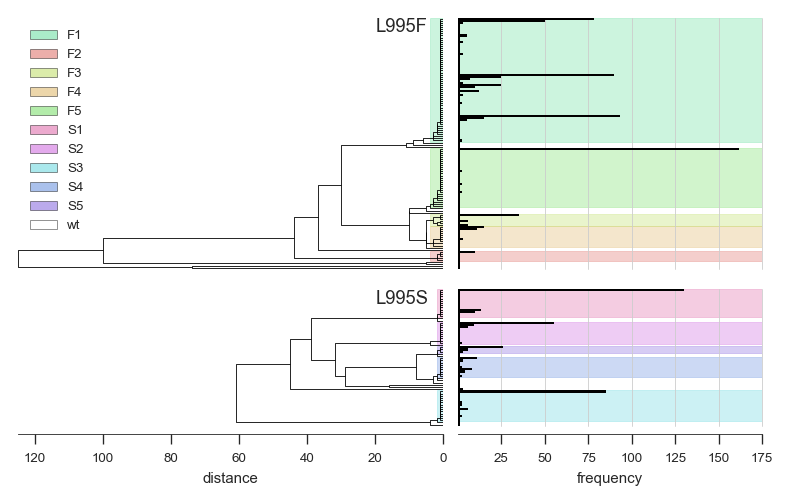

In [16]:
fig = plt.figure(figsize=(8, 4.5), dpi=120)

# define subplot layout
gs_nrows = 2
gs_ncols = 2
width_ratios = (1.4, 1)
height_ratios = (5.5, 3)
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.1 , wspace=0.04, width_ratios=width_ratios, height_ratios=height_ratios)

ax_dend = fig.add_subplot(gs[0, 0])
ax_freq = fig.add_subplot(gs[0, 1])
fig_haplotypes_clustered_piffle(h_vgsc_995F, orientation='left', dpi=150, 
                                ax_dend=ax_dend, ax_freq=ax_freq, 
                                highlight_clusters=5, label_clusters=None,
                                cut_height=4, highlight_colors=kdr_palette[0:5])

ax_dend = fig.add_subplot(gs[1, 0])
ax_freq = fig.add_subplot(gs[1, 1])
fig_haplotypes_clustered_piffle(h_vgsc_995S, orientation='left', dpi=150, 
                                ax_dend=ax_dend, ax_freq=ax_freq,
                                highlight_clusters=5, label_clusters=None, highlight_colors=kdr_palette[5:])

fig.savefig('/home/chris/Git/agam-vgsc-report/artwork/Figure_2_DendroFreqs.jpg')